# Multilayer perceptron jako ukázka NumPy

Ukázka možností knihovny NumPy - jednoduchý multilayer perceptron. 

Začneme základním importem:

In [36]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt



Budeme používat pseudonáhodný generátor pro počáteční nastavení vah. Abychom dostali při opakovaném spouštění programu stejné výsledky používáme metodu [numpy.random.seed()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html) která nastaví počáteční pseudonáhodné rozložení.

In [37]:
np.random.seed(42)

Pro aktivaci neuronů používáme aktivační funkci. 
Jednou ze základních možností je sigmoid. Pro jeho výpočet použijeme metodu [numpy.exp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html).
Stejně jako drtivá většina dalších funkcí v NumPy je to funkce vektorizovaná - automaticky umí pracovat s vektorem jako vstupem.

In [38]:
def sigmoid(vector):
    """
    Sigmoid activation function - vectorized
    """
    return 1 / (1 + np.exp(-vector))

Sigmoid je zajímavý mimo jiné tím, že má velice jednoduchou derivaci. A protože derivace se využívá při trénování perceptronu budeme potřebovat i funkci pro výpočet derivace sigmoidu. Opět vše je vektorizované, jednička se tedy odečte od všech hodnot vektoru activation atd.

In [39]:
def sigmoid_deriv(activation):
    """
    :param: activation - result of sigmoid activation function 
    derivative of sigmoid
    """
    return activation * (1 - activation)

Multilayer perceptron se skládá ze vstupní a výstupní vrstvy a dále určitého počtu skrytých vrstev (hidden layer).  **Jde vlastně o funkci, která mapuje hodnoty vstupy na výstup.**. V tomto případě budeme řešit jednoduchou regresi - pomocí trénovacích vytvoříme model funkce a pak jí využijeme pro odhad výsledku pro neznámé vstupy. Jde tedy o supervised learning - učení s učitelem. 

Pro jednoduchost příkladu použijeme pouze jednu skrytou vrstvu. Díky této jednoduché architektuře můžeme pro trénování perceptronu použít jen dvě funkce. 

Ve funkci **forward** provedeme výpočet vah a odhad finálního skóre. Z NumPy zde využijeme metodu pro výpočet skalárního součinu vektorů [numpy.dot()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html)

In [51]:
def forward(input, weights_1, weights_2):
    """
    forward propagation through our network
    """
    # dot product of X (input) and first set of 3x2 weights
    z = np.dot(input, weights_1)
    # sigmoid activation on first hidden layer
    activation_1 = sigmoid(z)  
    # dot product of hidden layer (z2) and second set of 3x1 weights
    z2 = np.dot(activation_1, weights_2)
    # output layer sigmoid activation
    activation_out = sigmoid(z2)

    return activation_1, activation_out


Průchod zpět je okamžikem, kdy se stroj učí. Určíme chybu odhadu a tu následně použijeme pro úpravu vah na všech vrstvách. Tento algoritmus se jmenuje [Backpropagation](https://en.wikipedia.org/wiki/Backpropagation) a používá se i v těch nejsložitějších sítích současnosti. 

In [52]:
def backward(X, y, pred, weights_1, weights_2, activation_1):
    # backward propgate through the network
    pred_error = y - pred  # error in prediction
    # applying derivative of sigmoid to error
    o_delta = pred_error * sigmoid_deriv(pred)

    # z2 error: how much our hidden layer weights contributed to output error
    z2_error = o_delta.dot(weights_2.T)
    # applying derivative of sigmoid to z2 error
    z2_delta = z2_error * sigmoid_deriv(activation_1)

    # adjusting first set (input --> hidden) weights
    weights_1 += X.T.dot(z2_delta)
    # adjusting second set (hidden --> output) weights
    weights_2 += activation_1.T.dot(o_delta)

    return weights_1, weights_2

## Trénování sítě

Zjednodušeně můžeme říct, že trénování sítě probíhá spočívá v opakovném střídání funkcí forward a backward. 
Periodicky necháváme síť odhadovat výsledek (forward) a následně
upravujeme váhy tak aby odhad byl co nejpřesnější (backward). 

Z NumPy funkcí je zde použito [náhodné generování](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randn.html) pro počáteční nastavení vah. 
A dále funkcí [np.mean](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html) a [np.square](https://docs.scipy.org/doc/numpy/reference/generated/numpy.square.html) pro výpočet [MSE](https://en.wikipedia.org/wiki/Mean_squared_error)

In [42]:
def train(steps, X_train, y_train):

    # (3x2) weight matrix from input to hidden layer
    W1 = np.random.randn(INPUT_SIZE, HIDDEN_SIZE)
    # (3x1) weight matrix from hidden to output layer
    W2 = np.random.randn(HIDDEN_SIZE, OUTPUT_SIZE)

    mses = []

    for i in range(steps):
        hidden, predict = forward(X_train, W1, W2)
        W1, W2 = backward(X_train, y_train, predict, W1, W2, hidden)
        MSE = np.mean(np.square(y - predict))
        mses.append(MSE)
        
    return W1, W2, mses   

In [54]:
def predict(X_test, weights_1, weights_2):

    # Final prediction
    print("Predicted data based on trained weights: ")
    print("Input (scaled): \n" + str(X_test))
    H, OUT = forward(X_test, weights_1, weights_2)
    print("Output: \n" + str(OUT))



## Data, parametry

Máme všechny funkce které budeme potřebovat. Můžeme se tedy pustit do tréninku. 

Předpokládejme, že existuje matematický vztah mezi počtem hodin spánku, počtem hodin studia a výsledým počtem bodů v náročném testu další den. Ŕekněme, že stačí se hodně učit a hodně spát a dobrý výsledek je zaručen. Uznávám, že život je složitější... :)

Pole X tedy představuje hodnoty vstupu - počet hodin studia a počet hodin spánku pro každého studenta. Pole y pak příslušný výsledek v testu. Hodnoty v obou polích jsou spárované přes index.

První student tedy studoval dvě hodiny a následně devět hodin spal a v testu dosáhl 92 bodů ze 100 možných. A tak dále.

In [56]:
X = np.array(([2, 9], [1, 5], [3, 6], [0, 1], [5, 9]), dtype=float)
y = np.array(([92], [51], [63], [11], [99]), dtype=float)

Vstupní vrstva tedy bude potřebovat dva neurony - máme dva parametry. 
Výstupní vrstva bude jeden neuron - odhadujeme hodnotu skóre. 
Počet neuronů skryté vrstvy i počet skrytých vrstev už tak přesně určit nemůžeme - patří mezi parametry modelu, 
které můžeme zkoumat a ladit. Takže zde pro jednoduchost dáme tři neurony a víc to nebudeme řešit.

In [58]:
INPUT_SIZE = 2
OUTPUT_SIZE = 1
HIDDEN_SIZE = 3

Protože hodnoty času mohou být na stupnici 0-24 a hodnoty testu na stupnici 0-100 provedeme jednoduché přeškálování čísel na hodnoty v rozsahu 0-1. 

In [61]:
X_test = np.array(([4, 8]), dtype=float)

# scale units
# maximum is 24 hours
X = X / 24
X_test = X_test / 24
# max test score is 100
y = y / 100

A konečně provedeme trénink i odhad testovací hodnoty.

In [62]:
W1, W2, loss_values = train(1500, X, y)
predict(X_test, W1, W2)

Predicted data based on trained weights: 
Input (scaled): 
[0.16666667 0.33333333]
Output: 
[0.01912366]


Vizualizace toho, jak v průběhu tréninku klesá chyba. Při studiu modelů je potřeba vědět, co se děje.

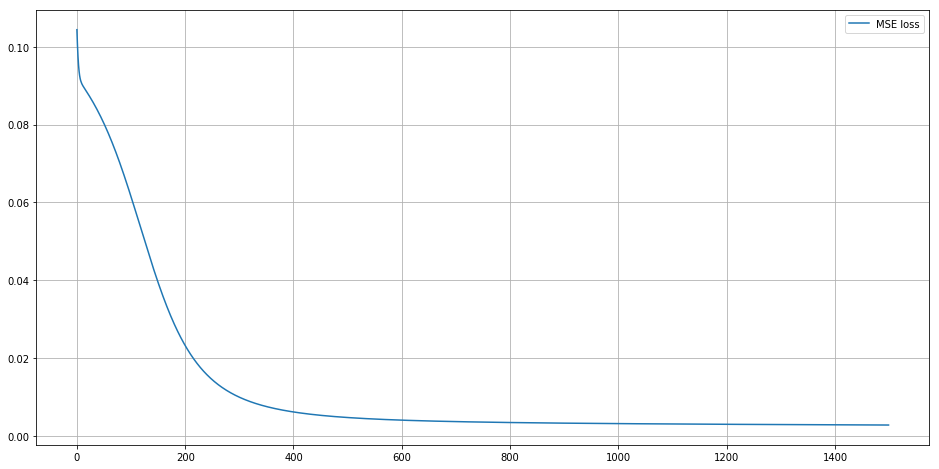

In [50]:
plt.plot(loss_values, label='MSE loss')
plt.legend(loc='best')
plt.rcParams['figure.figsize'] = (16,20)
plt.grid()
plt.show()
